In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import xml.etree.ElementTree as ET

# WP: Wahlperiode
# Quelle der Daten: 

In [2]:
DATA_PATH = Path('data')
MDB_XML_PATH = DATA_PATH / 'MDB_STAMMDATEN.XML'
DF_MDB_PATH = DATA_PATH / 'df_mdb.csv' #one row per individuum, one col per wp containing 0 / 1
DF_MDB_WP_PATH = DATA_PATH / 'df_mdb_wp.csv' # one row per individuum per wp, containting e.g. 12. so one abgeordneter who has been in parliament for several wp will receive one row per wp

# parse xml data into dataFrame / .csv fomat

In [3]:
def get_mdb_data(mdb_xml_path = MDB_XML_PATH):
    list_of_mdb = []
    MDB_STAMMDATEN = ET.parse(mdb_xml_path)
    root = MDB_STAMMDATEN.getroot()
    
    for mdb in root.findall('MDB'):
        mdb_dict = {}
        ID, NAMEN, BIOGRAFISCHE_ANGABEN, WAHLPERIODEN = mdb[0], mdb[1], mdb[2], mdb[3]

        mdb_dict['ID'] = ID.text
        mdb_dict['NACHNAME'] = NAMEN.find('NAME').find('NACHNAME').text  
        mdb_dict['VORNAME'] = NAMEN.find('NAME').find('VORNAME').text  

        #print(mdb.tag, mdb.text, mdb.findall('NACHNAME'))
        for element in BIOGRAFISCHE_ANGABEN:
            mdb_dict[element.tag] = element.text

        mdb_dict['ANZ_WAHLPERIODEN'] = len(list(WAHLPERIODEN))

        for wahlperiode in WAHLPERIODEN:
            mdb_dict[int(wahlperiode.find('WP').text)] = 1

        list_of_mdb.append(mdb_dict)
    return pd.DataFrame(list_of_mdb)

In [4]:
"""
def get_mdb_wp_data(mdb_xml_path = MDB_XML_PATH):
    list_of_mdb = []
    MDB_STAMMDATEN = ET.parse(mdb_xml_path)
    root = MDB_STAMMDATEN.getroot()
    
    for mdb in root.findall('MDB'):
        mdb_dict = {}
        ID, NAMEN, BIOGRAFISCHE_ANGABEN, WAHLPERIODEN = mdb[0], mdb[1], mdb[2], mdb[3]

        mdb_dict['ID'] = ID.text
        mdb_dict['NACHNAME'] = NAMEN.find('NAME').find('NACHNAME').text  
        mdb_dict['VORNAME'] = NAMEN.find('NAME').find('VORNAME').text  

        #print(mdb.tag, mdb.text, mdb.findall('NACHNAME'))
        for element in BIOGRAFISCHE_ANGABEN:
            mdb_dict[element.tag] = element.text

        mdb_dict['ANZ_WAHLPERIODEN'] = len(list(WAHLPERIODEN))

        for wahlperiode in WAHLPERIODEN:
            # one seperate entry per wp
            mdb_dict = mdb_dict.copy()
            mdb_dict['WP']=int(wahlperiode.find('WP').text)
            list_of_mdb.append(mdb_dict)
    return pd.DataFrame(list_of_mdb)
"""

"\ndef get_mdb_wp_data(mdb_xml_path = MDB_XML_PATH):\n    list_of_mdb = []\n    MDB_STAMMDATEN = ET.parse(mdb_xml_path)\n    root = MDB_STAMMDATEN.getroot()\n    \n    for mdb in root.findall('MDB'):\n        mdb_dict = {}\n        ID, NAMEN, BIOGRAFISCHE_ANGABEN, WAHLPERIODEN = mdb[0], mdb[1], mdb[2], mdb[3]\n\n        mdb_dict['ID'] = ID.text\n        mdb_dict['NACHNAME'] = NAMEN.find('NAME').find('NACHNAME').text  \n        mdb_dict['VORNAME'] = NAMEN.find('NAME').find('VORNAME').text  \n\n        #print(mdb.tag, mdb.text, mdb.findall('NACHNAME'))\n        for element in BIOGRAFISCHE_ANGABEN:\n            mdb_dict[element.tag] = element.text\n\n        mdb_dict['ANZ_WAHLPERIODEN'] = len(list(WAHLPERIODEN))\n\n        for wahlperiode in WAHLPERIODEN:\n            # one seperate entry per wp\n            mdb_dict = mdb_dict.copy()\n            mdb_dict['WP']=int(wahlperiode.find('WP').text)\n            list_of_mdb.append(mdb_dict)\n    return pd.DataFrame(list_of_mdb)\n"

In [37]:
def get_mdb_wp_data(df_mdb):
    """
    reformat
    peter | lustig | wp1 | wp2
    
    into
    peter | lustig | wp1
    peter | lustig | wp2
    """
    
    wps = [column for column in df_mdb.columns if isinstance(column, int)] # probably 1 to 19 or 20
    columns_to_keep = [column for column in df_mdb.columns if not isinstance(column, int)] # 'BERUF', 'VITA_KURZ' etc
    
    # should be 19 before 2021, 20 afterwards
    max_wp = max(wps)
    
    # this could be optimized but only runs once for about 2 Minutes
    new_entries = []
    for idx, row in df_mdb.iterrows():
        for wp in wps:
            if row[wp] == 1:
                new_entry = row[columns_to_keep]
                new_entry['WP'] = wp
                new_entries.append(new_entry)
    
    mdb_wp = pd.DataFrame(new_entries)
    return(mdb_wp)

In [38]:
df_mdb = get_mdb_data(MDB_XML_PATH)
print(df_mdb.shape)
df_mdb.head()

(4089, 34)


,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,2,12,13,14,15,16,1,17,18,19
0,11000001,Abelein,Manfred,20.10.1930,Stuttgart,None,17.01.2008,männlich,keine Angaben,katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11000002,Achenbach,Ernst,09.04.1909,Siegen,None,02.12.1991,männlich,"verheiratet, 3 Kinder",evangelisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11000003,Ackermann,Annemarie,26.05.1913,Parabutsch,Jugoslawien,18.02.1994,weiblich,"verheiratet, 5 Kinder",katholisch,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11000004,Ackermann,Else,06.11.1933,Berlin,None,14.09.2019,weiblich,ledig,evangelisch,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11000005,Adam,Ulrich,09.06.1950,"Teterow, Kr. Teterow, Bezirk Neubrandenburg",None,None,männlich,"verheiratet, 2 Kinder",evangelisch,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [39]:
df_mdb_wp = get_mdb_wp_data(df_mdb)

<AxesSubplot:>

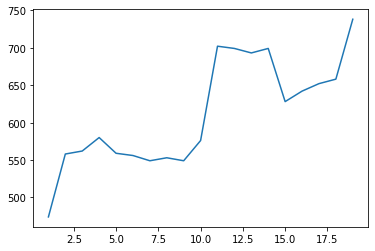

In [40]:
wps = [column for column in df_mdb.columns if isinstance(column, int)]
# aha: es werden immer mehr abgeordnete
df_mdb[wps].sum().sort_index().plot()

In [41]:
df_mdb[wps].sum().sort_index().tail()

15    628.0
16    642.0
17    652.0
18    658.0
19    738.0
dtype: float64

In [42]:
# total number of abgeordnete (counting multiple wps as multiple entries)
df_mdb[wps].sum().sum()

11627.0

In [43]:
df_mdb_wp.shape

(11627, 16)

In [44]:
df_mdb_wp[df_mdb_wp.NACHNAME =='Baerbock']

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,BERUF,PARTEI_KURZ,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,WP
3575,11004245,Baerbock,Annalena,15.12.1980,Hannover,None,None,weiblich,"verheiratet, 2 Kinder",evangelisch-lutherisch,Völkerrechtlerin,BÜNDNIS 90/DIE GRÜNEN,2000/04 Studium der Politikwissenschaft und Öf...,"5 Funktionen in Vereinen, Verbänden und Stiftu...",2,18
3575,11004245,Baerbock,Annalena,15.12.1980,Hannover,None,None,weiblich,"verheiratet, 2 Kinder",evangelisch-lutherisch,Völkerrechtlerin,BÜNDNIS 90/DIE GRÜNEN,2000/04 Studium der Politikwissenschaft und Öf...,"5 Funktionen in Vereinen, Verbänden und Stiftu...",2,19


# clean data 1. missing values

In [45]:
dimensions_replace_na = ['NACHNAME', 'VORNAME', 'GEBURTSDATUM', 'GEBURTSORT', 'GEBURTSLAND', 'STERBEDATUM', 'GESCHLECHT', 'FAMILIENSTAND', 'RELIGION', 'BERUF', 'PARTEI_KURZ']
df_mdb[dimensions_replace_na].isna().sum()

NACHNAME            0
VORNAME             0
GEBURTSDATUM        0
GEBURTSORT          4
GEBURTSLAND      4010
STERBEDATUM      2199
GESCHLECHT          0
FAMILIENSTAND      81
RELIGION          227
BERUF               3
PARTEI_KURZ         3
dtype: int64

In [46]:
df_mdb[dimensions_replace_na] = df_mdb[dimensions_replace_na].fillna('UNBEKANNT')

# 2. replacec values

In [47]:
df_mdb.PARTEI_KURZ.value_counts()[:12]

CDU                      1347
SPD                      1329
FDP                       460
CSU                       269
BÜNDNIS 90/DIE GRÜNEN     180
DIE LINKE.                128
AfD                        88
PDS                        54
GRÜNE                      51
DIE GRÜNEN/BÜNDNIS 90      28
DP                         27
FU                         21
Name: PARTEI_KURZ, dtype: int64

In [48]:
# ok, quite expected. some cleaning necessarry: 'BÜNDNIS 90/DIE GRÜNEN', 'DIE GRÜNEN/BÜNDNIS 90', 'GRÜNE'
for grünen_alias in ['BÜNDNIS 90/DIE GRÜNEN', 'DIE GRÜNEN/BÜNDNIS 90', 'GRÜNE']:
    df_mdb.replace(grünen_alias, 'DIE GRÜNEN', inplace=True)

In [49]:
df_mdb.RELIGION.value_counts().head(12)

ohne Angaben                 1214
evangelisch                  1154
katholisch                    870
römisch-katholisch            316
UNBEKANNT                     227
evangelisch-lutherisch        138
konfessionslos                118
evangelisch-reformiert         15
religionslos                    7
Atheistin                       6
muslimisch                      5
evangelisch-freikirchlich       3
Name: RELIGION, dtype: int64

In [50]:
for katholisch_alias in ['römisch-katholisch', 'alt-katholisch']:
    df_mdb.RELIGION.replace(katholisch_alias, 'katholisch', inplace=True)

In [51]:
for evangelisch_alias in ['evangelisch-lutherisch', 'evangelisch-reformiert', 'evangelisch-freikirchlich']:
    df_mdb.RELIGION.replace(evangelisch_alias, 'evangelisch', inplace=True)

In [52]:
# number of different jobs: 2k
len(set(df_mdb.BERUF))

2201

In [53]:
df_mdb['BERUF_MAPPED'] = df_mdb['BERUF'].copy()

In [54]:
df_mdb[['ID', 'BERUF']].groupby('BERUF').count().sort_values(by='ID', ascending=False).head(16)

,ID
BERUF,
Rechtsanwalt,182
Geschäftsführer,80
Landwirt,79
Angestellter,63
Rechtsanwalt und Notar,47
Kaufmann,45
Journalist,43
Hausfrau,41
Dipl.-Ingenieur,37


In [55]:
# leere einträge durch <unbekannt> ersetzen
df_mdb.BERUF_MAPPED.fillna('unbekannt', inplace=True)

# Geschäftsführer, Parl. Staatssekretär => Geschäftsführer, Rechtsanwalt, Parl. Staatssekretär a. D.' = 'Rechtsanwalt'
df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.apply(lambda beruf: beruf.split(',')[0])

#Bäckermeister und Konditor  => Bäckermeister, Rechtsanwalt und Fachanwalt für Steuerrecht  => Rechtsanwalt
df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.apply(lambda beruf: beruf.split(' und ')[0])

# Kaufmann / Informatiker => Kaufmann
df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.apply(lambda beruf: beruf.split(' / ')[0])

# Dipl.-Kaufmann => Kaufmann, Dipl.-Ingenieur => Ingenieur usw
df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace('Dipl.-', '')
df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace('Diplom-', '')
df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace('Diplom ', '')
df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace(' (FH)', '')
df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace(' (FH)', '')
df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace(' (BA)', '')
df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace(' (B. A.)', '')
df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace(' (MBA)', '')
df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace(' (M. Sc.)', '')
 
df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace(' a. D.', '')
df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace(' i. R.', '')

len(set(df_mdb.BERUF_MAPPED))

<ipython-input-55-0fd005d88285>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace('Dipl.-', '')
<ipython-input-55-0fd005d88285>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace(' (FH)', '')
<ipython-input-55-0fd005d88285>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace(' (FH)', '')
<ipython-input-55-0fd005d88285>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace(' (BA)', '')
<ipython-input-55-0fd005d88285>:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace(' (B. A.)', '')
<

1214

In [56]:
df_mdb.BERUF_MAPPED.replace(['Rechtsanwalt', 'Rechtsanwältin', 'Jurist', 'Juristin', 'Volljurist', 'Volljuristin',
                                'Oberstaatsanwalt', 'Oberstaatsanwältin','Staatsanwalt', 'Staatsanwältin',
                                'Rechtsanwalt und Notar', 'Richter', 'Richterin',
                               'Verwaltungsjurist', 'Verwaltungsjuristin', 'Steuerjurist', 'Steuerjuristin',
                                'Wirtschaftsjurist', 'Wirtschaftsjuristin',
                               'Notar', 'Notarin', 'Dr. jur.', 'Syndikus', 'Rechtsberater'], 'Jurist*in', inplace=True)

In [57]:
Jurist_String = df_mdb[df_mdb.BERUF_MAPPED.str.contains('nwalt', na=False) | (df_mdb.BERUF_MAPPED.str.contains('urist', na=False))].BERUF_MAPPED
#Kaufmann_Strings = df_mdb_wp[(df_mdb_wp.BERUF_MAPPED.str.contains('aufmann', na=False)) |(df_mdb_wp.BERUF_MAPPED.str.contains('auffrau', na=False))].BERUF_MAPPED 
df_mdb.BERUF_MAPPED.replace(list(Jurist_String), 'Jurist*in', inplace=True)

In [58]:
df_mdb.BERUF_MAPPED.replace(['Landwirt', 'Landwirtin', 'Landwirtschaftsmeister', 'Landwirtschaftsmeisterin', 
                                'Land-', 'Bauer', 
                                'Agraringenieur', 'Agraringenieurin', 'Agrarwissenschaftler', 'Agrarwissenschaftlerin', 
                                'Land- und Forstwirt', 'Ingenieur für Agrarwissenschaften', 'Forstwirt', 'Forstwirtin',
                               'Ökonomierat'], 'Land-/Forstwirt*in', inplace=True)

In [59]:
Landwirt_String = df_mdb[df_mdb.BERUF_MAPPED.str.contains('Forst', na=False) | (df_mdb.BERUF_MAPPED.str.contains('grar', na=False))].BERUF_MAPPED
#Kaufmann_Strings = df_mdb_wp[(df_mdb_wp.BERUF_MAPPED.str.contains('aufmann', na=False)) |(df_mdb_wp.BERUF_MAPPED.str.contains('auffrau', na=False))].BERUF_MAPPED 
df_mdb.BERUF_MAPPED.replace(list(Landwirt_String), 'Land-/Forstwirt*in', inplace=True)

In [60]:
Unternehmer_Strings = df_mdb[df_mdb.BERUF_MAPPED.str.contains('rnehmer', na=False)].BERUF_MAPPED
df_mdb.BERUF_MAPPED.replace(list(Unternehmer_Strings), 'Geschäftsführer*in/Unternehmer*in', inplace=True)

In [61]:
df_mdb.BERUF_MAPPED.replace(['Geschäftsführer', 'Geschäftsführerin', 'Hauptgeschäftsführer', 'Hauptgeschäftsführerin', 
                                'Unternehmer', 'Unternehmerin', 'Selbständiger Unternehmer', 'Selbständige Unternehmerin',
                               'Fabrikant', 'Fabrikantin'], 'Geschäftsführer*in/Unternehmer*in', inplace=True)

In [62]:
df_mdb.BERUF_MAPPED.replace(['Ingenieur', 'Ingenieurin', 'Ingenieur (FH)', 'Ingenieurin (FH)',
                               'Bauingenieur', 'Bauingenieurin', 'Maschinenbaumeister', 'Maschinenbaumeisterin',
                               'Bergingenieur', 'Bergingenieurin',
                               'Wirtschaftsingenieur', 'Wirtschaftsingenieurin'], 'Ingenieur*in', inplace=True)

In [63]:
Ingenieur_Strings = df_mdb[df_mdb.BERUF_MAPPED.str.contains('genieur', na=False)].BERUF_MAPPED
df_mdb.BERUF_MAPPED.replace(list(Ingenieur_Strings), 'Ingenieur*in', inplace=True)


In [64]:
df_mdb.BERUF_MAPPED.replace(['Journalist', 'Journalistin', 'Redakteur', 'Redakteurin', 
                               'Freier Journalist', 'Freie Journalistin', 'Fernsehjournalist', 'Fernsehjournalistin', 
                               'PR-Journalistin'], 'Journalist*in / Redakteur*in', inplace=True)

In [65]:
Journalist_Strings = df_mdb[df_mdb.BERUF_MAPPED.str.contains('edakteur', na=False)].BERUF_MAPPED
df_mdb.BERUF_MAPPED.replace(list(Journalist_Strings), 'Journalist*in / Redakteur*in', inplace=True)

In [66]:
Beamte_String = df_mdb[df_mdb.BERUF_MAPPED.str.contains('amte', na=False)].BERUF_MAPPED
df_mdb.BERUF_MAPPED.replace(list(Beamte_String), 'Angestellt[e] / Beamter*in', inplace=True)

In [67]:
df_mdb.BERUF_MAPPED.replace(['Angestellter', 'Angestellte', 'Regierungsdirektor', 'Regierungsdirektorin'], 'Angestellt[e] / Beamter*in', inplace=True)

In [68]:
Lehrer_Strings = df_mdb[df_mdb.BERUF_MAPPED.str.contains('ädagoge', na=False)].BERUF_MAPPED
df_mdb.BERUF_MAPPED.replace(list(Journalist_Strings), 'Lehrer*in / Rektor*in [a. D.]', inplace=True)

In [69]:
df_mdb.BERUF_MAPPED.replace(['Lehrer', 'Lehrerin', 'Erzieherin', 'Erzieher', 'Studienrat', 'Studienrätin', 'Oberstudienrat', 'Oberstudienrätin',
                                'Realschullehrer', 'Realschullehrerin', 'Oberlehrer', 'Gymnasiallehrerin', 'Gymnasiallehrer','Lehrer am Gymnasium (Oberstudienrat)',
                                'Oberstudienrat', 'Oberstudienrätin', 'Oberstudienrat a. D.', 
                                'Oberschulrat', 'Oberschulrätin',
                                'Studiendirektor', 'Studiendirektorin',
                                'Oberstudiendirektor', 'Oberstudiendirektorin','Direktor', 'Direktorin',
                                'Volkshochschuldirektor', 'Volkshochschuldirektorin', 'Realschuldirektor', 'Realschuldirektorin',
                                'Schuldirektor', 'Schuldirektorin', 'Hauptschuldirektor', 'Hauptschuldirektorin', 'Stadtschuldirektor', 'Stadtschuldirektorin',
                                'Rektor', 'Rektorin','Volksschulrektor', 'Volksschulrektorin','Gymnasialdirektor', 'Gymnasialdirektorin',
                                'Reallehrer', 'Reallehrerin','Realschulrektor', 'Realschulrektorin','Konrektor', 'Konrektorin',
                                'Konrektorin a.D.',
                                'Hauptschullehrerin', 'Hauptschullehrer','Hauptschulrat', 'Hauptschulrätin',
                                'Grund - u. Hauptschullehrer', 'Hauptlehrer', 'Hauptlehrerin',
                                'Sonderschullehrerin',  'Sonderschullehrer',
                                'Waldorflehrer', 'Waldorflehrerin',
                                'Berufsschullehrer', 'Berufschullehrerin', 'Sportlehrerin', 'Sportlehrer','Gymnastiklehrer', 'Gymnastiklehrerin',
                                'Lehrer Biologie/Chemie',
                                'Handelslehrer', 
                                'Fachhochschullehrer', 'Fachhochschullehrerin','Fachschullehrer', 'Fachschullehrerin',
                                'Handelslehrerin', 'Wirtschaftslehrerin', 'Technischer Lehrer', 
                                'Gewerbeschullehrer', 'Gewerbeschullehrerin','Fremdsprachenlehrer', 'Fremdsprachenlehrerin',
                                'Pädagoge', 'Pädagogin', 'Sozialpädagogin', 'Sozialpädagoge',
                                'Lehrer am katholischen Gymnasium Ravensburg','Lehrerin (Oberstudienrätin)','Lehrerin (StRin)', 'Lehrerin a. A.'], 
                               'Lehrer*in / Rektor*in [a. D.]', inplace=True)

In [70]:
Kaufmann_Strings = df_mdb[(df_mdb.BERUF_MAPPED.str.contains('aufmann', na=False)) |(df_mdb.BERUF_MAPPED.str.contains('auffrau', na=False))].BERUF_MAPPED 
df_mdb.BERUF_MAPPED.replace(list(Kaufmann_Strings), 'Kaufmann/-frau', inplace=True)

In [71]:
df_mdb.BERUF_MAPPED.replace(['Kaufmann', 'Kauffrau', 'Bürokauffrau', 'Bürokaufmann', 'Versicherungskaufmann', 'Versicherungskauffrau',
                                'Industriekaufmann', 'Industriekauffrau', 'Kaufmännischer Angestellter', 
                                'Bankkaufmann', 'Bankkauffrau', 'Einzelhandelskaufmann', 'Einzelhandelskauffrau',
                                'Baukaufmann', 'Baukauffrau',
                                'Großhandelskaufmann', 'Großhandelskauffrau',
                               'Hotelkauffrau', 'Hotelkaufmann', 'Selbständiger Kaufmann',
                               'Kaufmännische Angestellte', 'Kaufmännischer Angestellter', 'Kaufmännischer Direktor', 'Kaufmännische Direktorin'], 'Kaufmann/-frau', inplace=True)

In [72]:
df_mdb.BERUF_MAPPED.replace(['Volkswirt', 'Volkswirtin'], 'Volkswirtin*in', inplace=True)

In [73]:
Prof_Strings = df_mdb[df_mdb.BERUF_MAPPED.str.contains('Dozent', na=False)].BERUF_MAPPED
df_mdb.BERUF_MAPPED.replace(list(Prof_Strings), 'Professor*in', inplace=True)

In [74]:
# unnötig df_mdb_wp.BERUF_MAPPED.replace(['Fabrikant', 'Fabrikantin'], 'Fabrikant*in', inplace=True)
df_mdb.BERUF_MAPPED.replace(['Professor', 'Professorin', 'Universitätsprofessor', 'Universitätsprofessorin', 'Prof.',
                                'Hochschullehrer', 'Hochschullehrerin', 'Fachhochschulprofessor', 'Fachhochschulprofessorin',
                                'Dozent', 'Dozentin', 'Honorarprofessor', 'Honorarprofessorin',
                               'Lehrerin im Hochschuldienst', 'Studienrat im Hochschuldienst'], 'Professor*in', inplace=True)

In [75]:
# hihi gibt es nicht df_mdb_wp.BERUF_MAPPED.replace(['Hausfrau', 'Hausmann'], 'Hausfrau/-mann', inplace=True)
df_mdb.BERUF_MAPPED.replace(['Bundeskanzler', 'Bundeskanzlerin', 'Ministerpräsident', 'Ministerpräsidentin',
                                'Ministerpräsident des Freistaates Bayern',
                                'Bundestagspräsident', 'Bundestagspräsidentin',
                                'Präsident DBT', 'Präsidentin DBT', 'Vizepräsident DBT', 'Vizepräsidentin DBT', 'Vizepräsident des Deutschen Bundestages',
                                'Parl. Staatssekretär', 'Parl. Staatssekretärin',
                               'Präsident DBT a.D.', 'Präsidentin DBT a.D.',
                                'Landrat', 'Landrätin', 'Landrat a. D.', 'Landrätin a. D.',
                               'Bundesminister', 'Bundesministerin', 'Bundesminister a. D.',
                               'Bürgermeister', 'Bürgermeisterin', 'Oberbürgermeister', 'Oberbürgermeisterin',
                               'Amtsbürgermeister', 'Amtsbürgermeisterin', '1. Bürgermeister', '1. Bürgermeisterin',
                               'Bezirksbürgermeister', 'Bezirksbürgermeisterin', 'Erster Bürgermeister',
                               'Staatsminister', 'Staatsministerin', 'Staatsminister a. D.', 'Staatsminister a. D.',
                                 'Staatssekretär', 'Staatssekretärin',
                                'Ministerialdirektor', 'Ministerialdirektorin'
                               'Regierungsdirektor', 'Regierungsdirektorin', 'Regierungsdirektor a. D.', 'Regierungsdirektorin a. D.',
                                'Gemeindedirektor', 'Gemeindedirektorin', 'Stadtdirektor', 'Stadtdirektorin',
                                'Stadtdirektor', 'Stadtdirektorin'
                               'Oberregierungsrat', 'Oberregierungsrätin', 'Regierungsrat', 'Regierungsrätin', 
                                'Regierungspräsident', 'Regierungspräsidentin','Regierungsvizepräsident', 'Regierungsvizepräsidentin','Regierungspräsident z. D.',
                               'Ministerialrat', 'Ministerialrätin',
                                'Stadtamtmann', 'Stadtoberinspektor', 'Regierungsangestellter',
                               'Mitglied der Volkskammer', 'Landesgeschäftsführer'], 'Berufspolitiker', inplace=True)

In [76]:
df_mdb[df_mdb.BERUF_MAPPED.str.contains('egierung', na=False)].BERUF_MAPPED.value_counts()

Oberregierungsrat                        14
Regierungsangestellte                     2
Regierungsschuldirektorin                 1
Oberregierungsrat Bundesminister a.D.     1
Oberregierungslandwirtschaftsrat          1
Regierungs- u.Schulrat z. Wv.             1
Regierungsassessor                        1
Leitender Regierungsdirektor              1
Regierungsinspektor                       1
Name: BERUF_MAPPED, dtype: int64

In [77]:
Berufspolitiker_Strings = df_mdb[(df_mdb.BERUF_MAPPED.str.contains('inister', na=False))].BERUF_MAPPED 
df_mdb.BERUF_MAPPED.replace(list(Berufspolitiker_Strings), 'Berufspolitiker', inplace=True)

In [78]:
df_mdb.BERUF_MAPPED.replace(['Gewerkschaftssekretär', 'Gewerkschaftssekretärin'], 'Gewerkschaftssekretär*in', inplace=True)

In [79]:
df_mdb.BERUF_MAPPED.replace(['Arzt', 'Ärztin', 'Zahnarzt', 'Zahnärztin',
                                'Apotheker', 'Apothekerin', 'Tierarzt', 'Tierärztin',
                               'Medizinisch-technische Assistentin', 'Facharzt für innere Medizin', 'Facharzt für Innere Medizin'], 'Mediziner/ Ärztin', inplace=True)

In [80]:
df_mdb.BERUF_MAPPED.replace(['Pfarrer', 'Pfarrerin', 'Theologe', 'Theologin', 'Diakon', 'Diakonin'], 'Theologe*in', inplace=True)

In [81]:
df_mdb.BERUF_MAPPED.replace(['Betriebswirt', 'Betriebswirtin', 'Betriebswirt (FH)', 'Betriebswirtin (FH)', 
                                'Verwaltungsangestellter', 'Verwaltungsangestellterin',
                                'Verwaltungsleiter', 'Verwaltungsleiterin',
                                'Verwaltungswissenschaftler', 'Verwaltungswissenschaftlerin', 
                                'Verwaltungswirt', 'Verwaltungswirtin', 'Verwaltungswirt (FH)', 'Verwaltungswirtin (FH)',
                                'Oberlandwirtschaftsrat', 'Oberlandwirtschaftsrätin', 'Leitender Angestellter', 'Leitende Angestellte',
                                'Verwaltungsdirektor', 'Verwaltungsdirektorin', 'Verwaltungsangestellter', 'Verwaltungsangestellte',
                                'Sparkassenbetriebswirt', 'Sparkassenbetriebswirtin', 'Steuerberater', 'Steuerberaterin', 'Bankdirektor', 'Bankdirektorin'
                               ], 'Betriebswirt*in / Verwaltungsangestellte*r', inplace=True)

In [82]:
df_mdb.BERUF_MAPPED = df_mdb.BERUF_MAPPED.str.replace('Wirtschafts- und Sozialwissenschaftler', 'Wirtschaftswissenschaftler')
df_mdb.BERUF_MAPPED.replace(['Wirtschaftswissenschaftler', 'Wirtschaftswissenschaftler', 'Ökonom', 'Ökonomin', 
                                'Sozialökonom', 'Sozialökonomin', 
                                'Prokurist', 'Prokuristin'], 'Wirtschaftswissenschaftler*in', inplace=True)

In [83]:
df_mdb.BERUF_MAPPED.replace(['Politologe', 'Politologin', 'Politikwissenschaftler', 'Politikwissenschaftlerin', 
                                'Historiker', 'Historikerin', 
                                'Philosoph', 'Philosophin','Philologe', 'Philologin',
                                'Soziologe', 'Soziologin', 'Sozialwissenschaftler', 'Sozialwissenschaftlerin'], 'Geisteswissenschaftler*in', inplace=True)

In [84]:
df_mdb.BERUF_MAPPED.replace(['Chemiker', 'Chemikerin', 'Physiker', 'Physikerin', 'Pysiker', 
                                'Geophysiker', 'Geophysikerin', 'Biologe', 'Biologin', 'Physikochemiker',
                                'Mathematiker', 'Mathematikerin',
                               'Informatiker', 'Informatikerin',
                               'Technischer Angestellter', 'Technische Angestellte', 
                                'Wissenschaftlicher Mitarbeiter', 'Wissenschaftliche Mitarbeiterin',
                                'Wissenschaftlicher Assistent', 'Wissenschaftliche Assistentin'], 'Naturwissenschaftler*in', inplace=True)

In [85]:
df_mdb.BERUF_MAPPED.replace(['Schriftsetzer', 'Schriftsetzerin'], 'Schriftsetzer*in', inplace=True)

In [86]:
df_mdb.BERUF_MAPPED.replace(['Publizist', 'Publizistin', 'Verleger', 'Verlagsleiter'], 'Publizist*in', inplace=True)

In [87]:
# wenig!
df_mdb.BERUF_MAPPED.replace(['Psychologe', 'Psychologin', 'Beratender Diplompsychologe', 'Fachpsychologin der Medizin'], 'Psycholog*in', inplace=True)

In [88]:
#handwerker / Elektroniker / Mechaniker / Maurer / Schreiner / Tischler
df_mdb.BERUF_MAPPED.replace(['Elektroingenieur', 'Elektroingenieurin', 'Elektroinstallateur', 'Elektroinstallateurin',
                                'Elektromeister', 'Elektromeisterin', 'Elektromechaniker', 'Elektromechanikerin', 'Elektromonteur', 'Elektromonteurin',
                                'Elektroschweißer', 'Elektroschweißerin', 'Elektrotechniker', 'Elektrotechnikerin', 'Elektro-Techniker', 'Elektro-Technikerin',
                                'Elektroniker', 'Elektronikerin'
                                'Elektrohandwerksmeister', 'Elektrohandwerksmeisterin', 'Kraftfahrzeughandwerker', 'Kraftfahrzeughandwerkerin',
                                'Handwerksunternehmer', 'Handwerksunternehmerin', 'Elektro.-Ing.',
                                'Mechaniker', 'Mechanikerin', 'Feinmechaniker', 'Feinmechanikerin',
                                'Werkzeugmacher', 'Werkzeugmacherin', 'Ingenieur (FH) für Maschinenbau Werkzeugmacher',
                                'Kfz.-Mechaniker', 'Kfz.-Mechanikerin', 'Industriemechaniker', 'Industriemechanikerin',
                                'Selbständiger Kfz.-Mechanikermeister', 'Funkmechaniker', 'Funkmechaniker', 'Mechanikermeister', 'Härterfacharbeiter',
                                'Schlosser', 'Schlosserin','Maschinenschlosser', 'Maschinenschlosserin'
                                'Meister im Maurer- und Betonbauerhandwerk', 'Meister des Maler- und Lackierhandwerks',
                                'Maurer', 'Maurerin',
                                'Tischler', 'Tischlerin', 'Tischlermeister', 'Tischlermeisterin', 'Tischlergeselle', 'Tischlergesellin',
                                'Schreinermeister', 'Schreinermeisterin', 'Schreiner', 'Schreinerin', 'Modellschreiner', 'Modellschreinerin',
                                'Bäckermeister', 'Bäckerm.', 'Bäcker', 'Bäckerin', 'Bäcker- u. Konditormeister', 'selbstständiger Bäckermeister', 'Koch', 'Köchin',
                                'Müllermeister', 'Müllermeisterin', 'Bergmann'
                               ], 'Handwerker*in', inplace=True)

In [89]:
df_mdb[['ID', 'BERUF_MAPPED']].groupby('BERUF_MAPPED').count().sort_values(by='ID', ascending=False)[16:32]

,ID
BERUF_MAPPED,
Hausfrau,52
Theologe*in,36
Wirtschaftswissenschaftler*in,24
Publizist*in,23
Oberregierungsrat,14
Psycholog*in,12
Schriftsteller,12
Schriftsetzer*in,11
Sozialarbeiter,9


<AxesSubplot:xlabel='BERUF_MAPPED'>

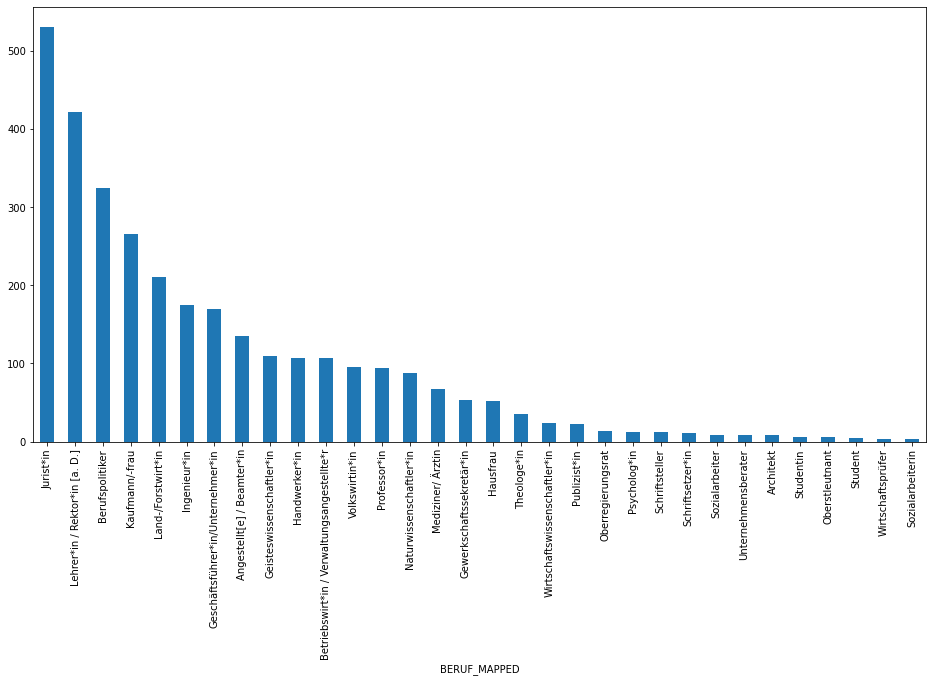

In [90]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
df_mdb.groupby('BERUF_MAPPED')['ID'].count().sort_values(ascending=False)[:32].plot(kind='bar')

In [91]:
len(set(df_mdb['BERUF_MAPPED']))

766

# construct df_mdb_wp

In [93]:
df_mdb_wp = get_mdb_wp_data(df_mdb)
print(df_mdb_wp.shape)

(11627, 17)


In [94]:
df_mdb_wp[df_mdb_wp.NACHNAME == 'Merkel'].head()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,BERUF,PARTEI_KURZ,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,BERUF_MAPPED,WP
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,Berufspolitiker,12
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,Berufspolitiker,13
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,Berufspolitiker,14
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,Berufspolitiker,15
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,Berufspolitiker,16


# save as csv

In [95]:
df_mdb.to_csv(DF_MDB_PATH, index=None)
df_mdb_wp.to_csv(DF_MDB_WP_PATH, index=None)

# read in data. exploratory data analysis

In [99]:
df_mdb = pd.read_csv(DF_MDB_PATH, index_col=None)
df_mdb_wp = pd.read_csv(DF_MDB_WP_PATH, index_col=None)

In [100]:
df_mdb.columns

Index(['ID', 'NACHNAME', 'VORNAME', 'GEBURTSDATUM', 'GEBURTSORT',
       'GEBURTSLAND', 'STERBEDATUM', 'GESCHLECHT', 'FAMILIENSTAND', 'RELIGION',
       'BERUF', 'PARTEI_KURZ', 'VITA_KURZ', 'VEROEFFENTLICHUNGSPFLICHTIGES',
       'ANZ_WAHLPERIODEN', '5', '6', '7', '8', '9', '10', '11', '3', '4', '2',
       '12', '13', '14', '15', '16', '1', '17', '18', '19', 'BERUF_MAPPED'],
      dtype='object')

In [101]:
df_mdb.tail()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,12,13,14,15,16,1,17,18,19,BERUF_MAPPED
4084,11004958,Nölke,Matthias,08.01.1980,Kassel,UNBEKANNT,UNBEKANNT,männlich,ledig,konfessionslos,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Jurist*in
4085,11004959,Martin,Dorothee,21.01.1978,UNBEKANNT,UNBEKANNT,UNBEKANNT,weiblich,UNBEKANNT,UNBEKANNT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Selbstständige Kommunikationsberaterin
4086,11004960,Wetzel,Wolfgang,11.05.1968,Schlema,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 2 Kinder",katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Lehrer*in / Rektor*in [a. D.]
4087,11004961,Natterer,Christian,19.02.1981,Tettnang / Deutschland,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 1 Kind",katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Kaufmann/-frau
4088,11004962,Dahmen,Janosch,06.09.1981,UNBEKANNT,UNBEKANNT,UNBEKANNT,männlich,UNBEKANNT,UNBEKANNT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Mediziner/ Ärztin


In [102]:
df_mdb_wp[['ID', 'WP']].groupby('WP').count().sort_values(by='WP', ascending=False).head()

,ID
WP,
19,738
18,658
17,652
16,642
15,628


In [103]:
df_mdb_wp[['ID', 'PARTEI_KURZ']].groupby('PARTEI_KURZ').count().sort_values(by='ID', ascending=False).head(10)

,ID
PARTEI_KURZ,
SPD,4250
CDU,4150
FDP,1036
CSU,993
DIE GRÜNEN,536
DIE LINKE.,297
AfD,90
PDS,77
Plos,41


In [104]:
# wie - nur 2 Geschlechter? for the records: heute ist der 02.05.2021
df_mdb_wp[['ID', 'GESCHLECHT']].groupby('GESCHLECHT').count().sort_values(by='ID', ascending=False).head()

,ID
GESCHLECHT,
männlich,9382
weiblich,2245


In [105]:
# auch hier: such diversity. wow
df_mdb_wp[['ID', 'RELIGION']].groupby('RELIGION').count().sort_values(by='ID', ascending=False).head(n=16)

,ID
RELIGION,
katholisch,3817
evangelisch,3815
ohne Angaben,3275
UNBEKANNT,428
konfessionslos,234
Atheistin,12
Islam,9
religionslos,9
freireligiös,8


In [106]:
# jetzt wirds richtig vielseitig. so viele Busfahrer und Krankenschwestern!
df_mdb_wp[['ID', 'BERUF']].groupby('BERUF').count().sort_values(by='ID', ascending=False).head(16).head(16)

,ID
BERUF,
Rechtsanwalt,567
Geschäftsführer,223
Landwirt,212
Angestellter,190
Rechtsanwalt und Notar,126
Journalist,117
Dipl.-Ingenieur,109
Kaufmann,104
Jurist,102


In [107]:
# jetzt wirds richtig vielseitig. so viele Busfahrer und Krankenschwestern!
df_mdb_wp[['ID', 'BERUF_MAPPED']].groupby('BERUF_MAPPED').count().sort_values(by='ID', ascending=False).head(16).head(16)

,ID
BERUF_MAPPED,
Jurist*in,1678
Lehrer*in / Rektor*in [a. D.],1234
Berufspolitiker,1187
Kaufmann/-frau,682
Land-/Forstwirt*in,593
Ingenieur*in,511
Geschäftsführer*in/Unternehmer*in,447
Angestellt[e] / Beamter*in,386
Betriebswirt*in / Verwaltungsangestellte*r,334


In [108]:
# gehen sie weiter. hier gibt es kein Klischee zu erkennen!
df_mdb_wp[['ID', 'FAMILIENSTAND']].groupby('FAMILIENSTAND').count().sort_values(by='ID', ascending=False).head(16)

,ID
FAMILIENSTAND,
"verheiratet, 2 Kinder",2726
"verheiratet, 3 Kinder",1816
verheiratet,1720
"verheiratet, 1 Kind",1365
keine Angaben,1043
"verheiratet, 4 Kinder",891
ledig,424
"verheiratet, 5 Kinder",329
"verheiratet, 6 Kinder",178


In [109]:
# deleteme
start_date=16
end_date=18
#wps = range(start_date, end_date)
#selected_df = pd.concat([df_mdb[df_mdb[str(i)] == 1] for i in range(start_date,end_date+1)]).drop_duplicates()# deleteme
selected_df = df_mdb_wp[(df_mdb_wp['WP']>= start_date) & (df_mdb_wp['WP']<= end_date)].sort_values(by='VEROEFFENTLICHUNGSPFLICHTIGES')
selected_df.head()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,BERUF,PARTEI_KURZ,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,BERUF_MAPPED,WP
11306,11004450,Zech,Tobias,09.07.1981,Trostberg,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 2 Kinder",katholisch,Geschäftsführer,CSU,1994/98 Wirtschaftsschule Mühldorf. 1998/2000 ...,1 Berufliche Tätigkeit vor der Mitgliedschaft ...,2,Geschäftsführer*in/Unternehmer*in,18
10950,11004229,Reinhold,Hagen,23.03.1978,Wismar,UNBEKANNT,UNBEKANNT,männlich,3 Kinder,konfessionslos,Meister im Maurer- und Betonbauerhandwerk,FDP,"1994/97 Ausbildung zum Maurer und Betonbauer, ...",1 Berufliche Tätigkeit vor der Mitgliedschaft ...,2,Meister im Maurer-,17
10491,11004004,Aumer,Peter,17.04.1976,Regensburg,UNBEKANNT,UNBEKANNT,männlich,ledig,katholisch,Dipl.-Betriebswirt (FH),CSU,Berufsausbildung zum Steuerfachgehilfen. Studi...,1 Berufliche Tätigkeit vor der Mitgliedschaft ...,2,Betriebswirt*in / Verwaltungsangestellte*r,17
10886,11004179,Vogel,Johannes,29.04.1982,Wermelskirchen,UNBEKANNT,UNBEKANNT,männlich,verheiratet,evangelisch,Politikwissenschaftler,FDP,2001 Abitur am Städtischen Gymnasium Wermelski...,1 Berufliche Tätigkeit vor der Mitgliedschaft ...,2,Geisteswissenschaftler*in,17
11171,11004371,Paschke,Markus,08.06.1963,Bremen,UNBEKANNT,UNBEKANNT,männlich,verheiratet,ohne Angaben,Gewerkschaftssekretär,SPD,Gymnasium in Bremen. 1980/83 Ausbildung zum In...,1 Berufliche Tätigkeit vor der Mitgliedschaft ...,2,Gewerkschaftssekretär*in,18


In [110]:
# deleteme BEGIN

In [111]:
df_mdb_wp.shape

(11627, 17)

In [112]:
import logging
def replace_sonstige(df_mdb, df_mdb_wp, dimension='PARTEI_KURZ', num_keep = 7):
    """
    keep num_keep most occurences, replace other values by "sonstige"
    """
    
    # e.g. 'CDU', 'SPD'
    values_to_keep = list(df_mdb_wp[['ID', dimension]].groupby(dimension).count().sort_values(by='ID', ascending=False)[:num_keep].index)
    values_to_discard = list(df_mdb[['ID', dimension]].groupby(dimension).count().sort_values(by='ID', ascending=False)[num_keep:].index)
    
    logging.info(f'[{dimension}]. keeping {values_to_keep}. replacing {values_to_discard[:4]} ... with <sonstige>')
    df_mdb[dimension].replace(values_to_discard, 'sonstige', inplace=True)
    df_mdb_wp[dimension].replace(values_to_discard, 'sonstige', inplace=True)
    
    return values_to_keep, values_to_discard, df_mdb, df_mdb_wp

list_of_parteien, list_of_parteien_discard, df_mdb, df_mdb_wp = replace_sonstige(df_mdb, df_mdb_wp, dimension='PARTEI_KURZ', num_keep = 8)
list_of_religion, list_of_religion_discard, df_mdb, df_mdb_wp = replace_sonstige(df_mdb, df_mdb_wp, dimension='RELIGION', num_keep = 6) 
list_of_familienstand, list_of_familienstand_discard, df_mdb, df_mdb_wp = replace_sonstige(df_mdb, df_mdb_wp, dimension='FAMILIENSTAND', num_keep = 8)
list_of_beruf, list_of_beruf_discard, df_mdb, df_mdb_wp = replace_sonstige(df_mdb, df_mdb_wp, dimension='BERUF_MAPPED', num_keep = 12)

# append 'sonstige' to list of valid values
for list_of_values in [list_of_parteien, list_of_religion, list_of_familienstand, list_of_beruf]:
    list_of_values += ['sonstige']

In [113]:
df_mdb_wp[['ID', 'PARTEI_KURZ']].groupby('PARTEI_KURZ').count().iloc[0]
print(df_mdb_wp.shape)

(11627, 17)


In [131]:
# deleteme START

In [142]:
start_date = 1
end_date = 19
df_mdb_wp[df_mdb_wp.PARTEI_KURZ == 'AfD'].groupby('WP').count()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,BERUF,PARTEI_KURZ,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,BERUF_MAPPED
WP,,,,,,,,,,,,,,,,
14,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
15,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
19,88,88,88,88,88,88,88,88,88,88,88,88,88,83,88,88


In [135]:
df_mdb_wp[df_mdb_wp.PARTEI_KURZ=='AfD'].groupby('GESCHLECHT').count()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,FAMILIENSTAND,RELIGION,BERUF,PARTEI_KURZ,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,BERUF_MAPPED,WP
GESCHLECHT,,,,,,,,,,,,,,,,
männlich,81,81,81,81,81,81,81,81,81,81,81,81,77,81,81,81
weiblich,9,9,9,9,9,9,9,9,9,9,9,9,8,9,9,9


In [116]:
logging.getLogger().setLevel(logging.INFO)

dimension = 'PARTEI_KURZ'
logging.info(f'+++++ starting evaluation of {dimension}')
logging.info(f'1. before selecting:{dimension} {df_mdb_wp.shape[0]}')


selected_df = df_mdb_wp[(df_mdb_wp['WP']>= start_date) & (df_mdb_wp['WP']<= end_date)]
logging.info(f'2. after selecting wp: {dimension} {selected_df.shape[0]}')

INFO:root:+++++ starting evaluation of PARTEI_KURZ
INFO:root:1. before selecting:PARTEI_KURZ 11627
INFO:root:2. after selecting wp: PARTEI_KURZ 11627


In [122]:
selected_df[selected_df.PARTEI_KURZ == 'AfD'].shape

(90, 17)

In [128]:
selected_parteien = ['AfD']
selected_berufe = list_of_beruf

In [129]:
selected_df_1 = selected_df[selected_df['PARTEI_KURZ'].isin(selected_parteien)]
logging.info(f'3. after selecting party: {selected_df_1.shape[0]}')
selected_df[selected_df.PARTEI_KURZ == 'AfD'].shape

INFO:root:3. after selecting party: 90


(90, 17)

In [130]:
# select berufe
selected_df = selected_df[selected_df['BERUF_MAPPED'].isin(selected_berufe)]
logging.info(selected_berufe)
logging.info(f'4. after selecting beruf: {selected_df.shape[0]}')
selected_df[selected_df.PARTEI_KURZ == 'AfD'].shape

INFO:root:['Jurist*in', 'Lehrer*in / Rektor*in [a. D.]', 'Berufspolitiker', 'Kaufmann/-frau', 'Land-/Forstwirt*in', 'Ingenieur*in', 'Geschäftsführer*in/Unternehmer*in', 'Angestellt[e] / Beamter*in', 'Betriebswirt*in / Verwaltungsangestellte*r', 'Handwerker*in', 'Volkswirtin*in', 'Geisteswissenschaftler*in', 'sonstige']
INFO:root:4. after selecting beruf: 11627


(90, 17)

In [ ]:
# deleteme END

In [ ]:
# deleteme
# keep occurences
NUM_DIM_KEEP = 8
values_to_keep = selected_df[['ID', 'FAMILIENSTAND']].groupby('FAMILIENSTAND').count().sort_values(by='ID', ascending=False).index[NUM_DIM_KEEP:2*NUM_DIM_KEEP]
values_to_keep

In [ ]:
levels = [values_to_keep, range(start_date, end_date+1)]
levels

In [ ]:
new_index = pd.MultiIndex.from_product(levels, names=['FAMILIENSTAND', 'WP'])
new_index

In [ ]:
# deleteme
grouped = selected_df[['ID', 'WP', 'FAMILIENSTAND']].groupby(['FAMILIENSTAND', 'WP']).count()
grouped.head(16)

In [ ]:
grouped = grouped.reindex(new_index, fill_value=0)
grouped

In [ ]:
grouped.reset_index(inplace=True)
grouped

In [ ]:
# deleteme
wps = sorted(list(set(grouped.WP)))
familienstands = list(set(grouped.FAMILIENSTAND))
traces_values = []


In [ ]:
for familienstand in familienstands:
    trace = grouped[grouped['FAMILIENSTAND'] == familienstand].sort_values(by='WP').ID.values
    traces_values.append(trace)
traces_values

# quality checks

In [ ]:
df_mdb_wp[(df_mdb_wp.WP==19) & (df_mdb_wp.PARTEI_KURZ == 'CDU')]

In [ ]:
df_mdb_wp[(df_mdb_wp.WP==18) & (df_mdb_wp.PARTEI_KURZ == 'CDU') & (df_mdb_wp.BERUF.str.contains('Bürgermeister'))]